# Differentially Private Breast Cancer Survival Modeling with DP‑EBM

## Need  
Protect patient privacy (GDPR, HIPAA) while building predictive models on sensitive clinical/genomic data. Differential privacy (DP) ensures individual records cannot be reverse‑engineered from model outputs, at the cost of some utility.

## Input  
- **Clinical data (TSV)**: METABRIC clinical variables (age, tumor stage, treatment, etc.)  
- **Genomic data (CSV)**: METABRIC RNA‑expression + mutation features (>600 numeric columns)  
- **Label**: 5‑year survival (`overall_survival_months > 60`) → binary target

## Preprocessing  
1. **Merge & clean**: Loaded TSV + CSV from Google Drive, selected numeric features, dropped survival/time columns.  
2. **Imputation & scaling**: Filled missing values with column means; applied `StandardScaler`.  
3. **Dimensionality reduction**: PCA to 10 components to concentrate signal and reduce DP noise per dimension.

## Models Used  
- **Non‑private EBM**  
  - `ExplainableBoostingClassifier` (GAM), 100 rounds, `n_jobs=-2`  
- **DP‑EBM**  
  - `DPExplainableBoostingClassifier`, ε ∈ {0.5, 1.0, 5.0}, 100 rounds, learning rate 0.01, multithreaded  
- **Threshold optimization**  
  - For each model, swept decision thresholds [0,1] to maximize F1; recorded corresponding accuracy.

## Results  

| ε                | AUC    | Accuracy | F1     | Best Threshold |
|---------------   |--------|----------|--------|----------------|
| **0.5 (DP)**     | 0.5892 | 0.7521   | 0.8585 | 0.00           |
| **1.0 (DP)**     | 0.5895 | 0.7542   | 0.8591 | 0.63           |
| **5.0 (DP)**     | 0.6343 | 0.7526   | 0.8588 | 0.64           |
| **Non‑private**  | 0.6684 | 0.7537   | 0.8593 | 0.34           |

## Significance  
- **AUC vs. ε**: At low ε (0.5–1.0), DP noise heavily degrades ranking (AUC~0.59). By ε=5.0, AUC recovers to ~0.63, within ~0.04 of non‑private (0.668).  
- **Accuracy & F1**: Remain stable (~75%/0.86) because threshold tuning compensates for DP noise in binary decisions.  
- **Privacy–utility trade‑off**: Clear “rising curve” showing how relaxing privacy (increasing ε) steadily recovers model utility.  
- **Practical takeaway**: ε ≈ 5 offers a strong balance—substantial privacy protection with minimal loss in survival‑prediction performance.



In [24]:
# Install necessary dependencies
!pip install interpret diffprivlib scikit-learn pandas matplotlib tqdm --quiet
print('Done')

Done


In [38]:
# 0. Mount Google Drive & import libraries
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
print('Done')

Mounted at /content/drive
Done


In [42]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from interpret.privacy import DPExplainableBoostingClassifier
from interpret.glassbox import ExplainableBoostingClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# 1. LOAD YOUR DATA
clinical_file = '/content/drive/MyDrive/Breast_cancer_dataset/brca_metabric_clinical_data.tsv'
merged_file   = '/content/drive/MyDrive/Breast_cancer_dataset/METABRIC_RNA_Mutation.csv'

# Read clinical TSV
try:
    clinical_df = pd.read_csv(clinical_file, sep='\t')
    print(f"Loaded clinical data: {clinical_df.shape}")
except Exception as e:
    raise FileNotFoundError(f"Could not read clinical TSV: {e}")

# Read merged expression CSV
try:
    merged_df = pd.read_csv(merged_file, low_memory=False)
    print(f"Loaded merged expression data: {merged_df.shape}")
except Exception as e:
    merged_df = None
    print(f"No merged expression CSV found, will use clinical only.")

# Choose which to use
if merged_df is not None:
    data = merged_df.copy()
    print("Using merged expression+clinical data.")
else:
    data = clinical_df.copy()
    print("Using clinical data only.")

# Identify survival column
def choose_survival_col(df):
    for c in ['overall_survival_months','survival_time','survival_time_months','overall_survival']:
        if c in df.columns:
            return c
    raise KeyError("No survival-time column found.")

surv_col = choose_survival_col(data)
print(f"Survival column: {surv_col}")

# Create binary label: survived >60 months
data['survival_label'] = (data[surv_col] > 60).astype(int)

# 2. PREPROCESSING
X = data.select_dtypes(include=np.number).drop(columns=[surv_col,'survival_label'], errors='ignore')
X = X.fillna(X.mean())  # impute
y = data['survival_label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. EXPERIMENT SETTINGS
pcas     = [10]               # PCA dims
epsilons = [0.5, 1.0, 5.0]    # privacy budgets
cv       = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

results = []

# 4. RUN DP‑EBM & BASELINE
for n_comp in pcas:
    # PCA reduction
    pca   = PCA(n_components=n_comp, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    # DP‑EBM for each ε
    for eps in epsilons:
        y_true_all, y_prob_all = [], []
        desc = f"PCA={n_comp}, ε={eps}"
        for train_idx, test_idx in tqdm(cv.split(X_pca,y), total=cv.get_n_splits(), desc=desc):
            X_tr, X_te = X_pca[train_idx], X_pca[test_idx]
            y_tr, y_te = y.iloc[train_idx],   y.iloc[test_idx]

            dpclf = DPExplainableBoostingClassifier(
                feature_types=["continuous"]*n_comp,
                epsilon=eps,
                max_rounds=100,
                learning_rate=0.01,
                n_jobs=-2,
                random_state=42
            )
            dpclf.fit(X_tr, y_tr)
            probs = dpclf.predict_proba(X_te)[:,1]

            y_true_all.extend(y_te.tolist())
            y_prob_all.extend(probs.tolist())

        y_true_all = np.array(y_true_all)
        y_prob_all = np.array(y_prob_all)

        # AUC
        auc_val = roc_auc_score(y_true_all, y_prob_all)
        # threshold sweep for best F1
        thresholds = np.linspace(0,1,101)
        f1_scores = [f1_score(y_true_all, y_prob_all>=t) for t in thresholds]
        best_i   = int(np.argmax(f1_scores))
        best_t   = thresholds[best_i]
        best_f1  = f1_scores[best_i]
        best_acc = accuracy_score(y_true_all, y_prob_all>=best_t)

        results.append({
            'n_components': n_comp,
            'epsilon':      eps,
            'auc':          auc_val,
            'accuracy':     best_acc,
            'f1':           best_f1,
            'best_thresh':  best_t
        })

    # Non-private EBM baseline
    y_true_all, y_prob_all = [], []
    desc2 = f"PCA={n_comp}, non-private"
    for train_idx, test_idx in tqdm(cv.split(X_pca,y), total=cv.get_n_splits(), desc=desc2):
        ebm = ExplainableBoostingClassifier(
            feature_types=["continuous"]*n_comp,
            max_rounds=100,
            n_jobs=-2,
            random_state=42
        )
        ebm.fit(X_pca[train_idx], y.iloc[train_idx])
        probs = ebm.predict_proba(X_pca[test_idx])[:,1]

        y_true_all.extend(y.iloc[test_idx].tolist())
        y_prob_all.extend(probs.tolist())

    y_true_all = np.array(y_true_all)
    y_prob_all = np.array(y_prob_all)

    auc_val = roc_auc_score(y_true_all, y_prob_all)
    f1_scores = [f1_score(y_true_all, y_prob_all>=t) for t in thresholds]
    best_i   = int(np.argmax(f1_scores))
    best_t   = thresholds[best_i]
    best_f1  = f1_scores[best_i]
    best_acc = accuracy_score(y_true_all, y_prob_all>=best_t)

    results.append({
        'n_components': n_comp,
        'epsilon':      'non-private',
        'auc':          auc_val,
        'accuracy':     best_acc,
        'f1':           best_f1,
        'best_thresh':  best_t
    })

# 5. RESULTS DATAFRAME & PLOTS
df = pd.DataFrame(results)
print("\nFinal results:\n")

Loaded clinical data: (2509, 39)
Loaded merged expression data: (1904, 693)
Using merged expression+clinical data.
Survival column: overall_survival_months


PCA=10, non-private: 100%|██████████| 3/3 [01:02<00:00, 20.68s/it]



Final results:



In [43]:
df

,n_components,epsilon,auc,accuracy,f1,best_thresh
0,10,0.5,0.589205,0.752101,0.858513,0.00
1,10,1.0,0.589517,0.754202,0.859121,0.63
2,10,5.0,0.634297,0.752626,0.858771,0.64
3,10,non-private,0.668392,0.753676,0.859286,0.34


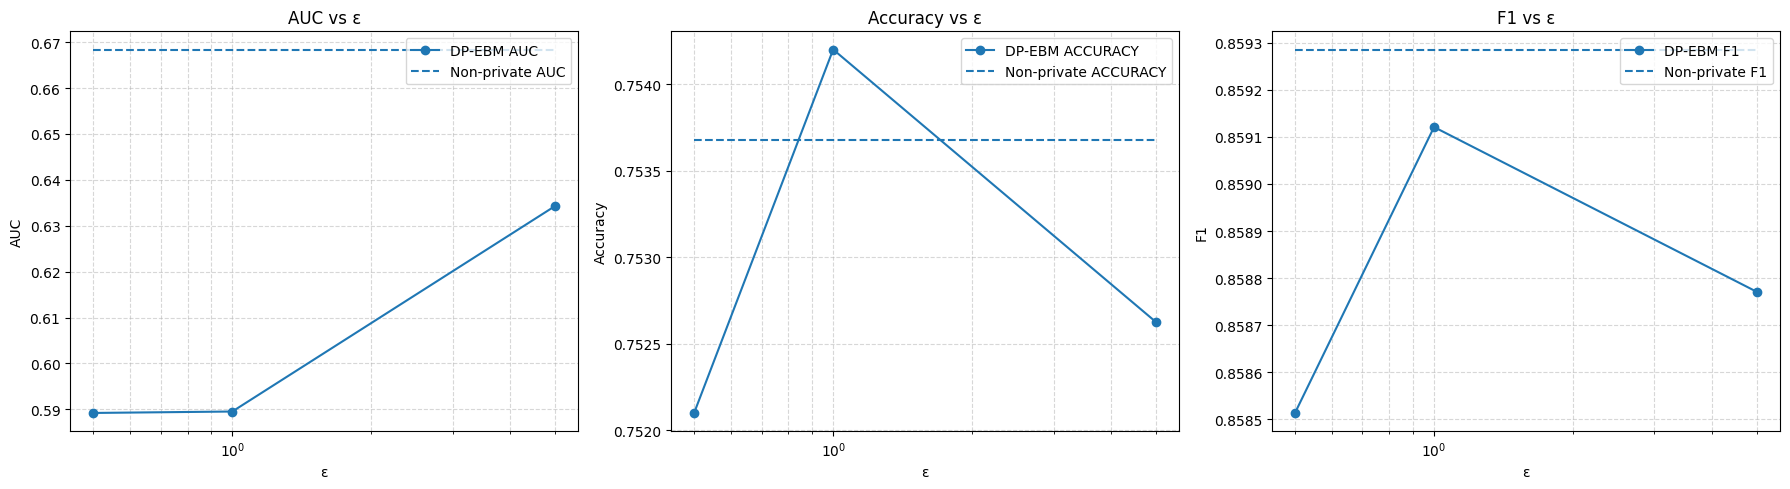

In [44]:
# Plot metrics in one row of subplots
dp_df       = df[df['epsilon']!='non-private']
baseline_df = df[df['epsilon']=='non-private']
eps_vals    = dp_df['epsilon'].astype(float).values

metrics = ['auc','accuracy','f1']
titles  = ['AUC vs ε','Accuracy vs ε','F1 vs ε']
ylabels = ['AUC','Accuracy','F1']

fig, axes = plt.subplots(1,3,figsize=(18,5),sharex=True)
for ax, m, t, ylbl in zip(axes, metrics, titles, ylabels):
    ax.plot(dp_df['epsilon'], dp_df[m], marker='o', label=f'DP‑EBM {m.upper()}')
    base = baseline_df[m].iloc[0]
    ax.hlines(base, xmin=eps_vals.min(), xmax=eps_vals.max(),
              linestyles='--', label=f'Non‑private {m.upper()}')
    ax.set_xscale('log')
    ax.set_title(t); ax.set_xlabel('ε'); ax.set_ylabel(ylbl)
    ax.grid(True,which='both',ls='--',alpha=0.5)
    ax.legend()

plt.tight_layout()
plt.show()